In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [18]:
path_to_main= 'airfoil2d/'
folders=os.listdir(path_to_main)
df = np.empty((0,66,256,4))
df_label = np.empty((0,66,256,4))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(1237, 66, 256, 4)


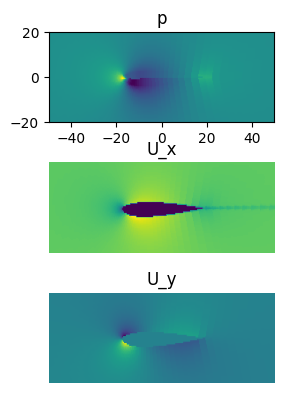

In [48]:
fig = plt.figure()
n=530

fig.add_subplot(3, 2, 1)
plt.imshow(df_label[n,:,:,3],extent=[-50,50,-20,20])
plt.title('p')
plt.axis('on')


fig.add_subplot(3, 2, 3)
plt.imshow(df_label[n,:,:,0],extent=[-50,50,-20,20])
plt.title('U_x')
plt.axis('off')

fig.add_subplot(3, 2, 5)
plt.imshow(df_label[n,:,:,1],extent=[-50,50,-20,20])
plt.title('U_y')
plt.axis('off')

plt.show()

In [51]:
df_label[n,:,:,3].shape

(66, 256)

In [9]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))

normal=np.array([U_max,U_max,U_max, p_max]).reshape(1,1,1,4)
print(normal)
df=df/normal
df_label=df_label/normal

[[[[4.49073389e+03 4.49073389e+03 4.49073389e+03 4.06376920e+07]]]]


In [10]:
train_data, test_data, label_train, label_test = train_test_split (df, df_label, test_size = 0.15)

In [11]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(4,(2, 8), (2, 8), activation='tanh', input_shape=(66,256, 4)))
model.add(layers.Conv2D(32,(3, 4), (3, 4), activation='tanh',))
model.add(layers.Conv2D(256,(11, 8), (11, 8), activation='tanh',))
model.add(layers.Conv2DTranspose(32,(11,8),(11,8), activation='tanh'))
model.add(layers.Conv2DTranspose(4,(3,4),(3,4), activation='tanh'))
model.add(layers.Conv2DTranspose(4,(2,8),(2,8), activation='PReLU'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 4)         260       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 32)         1568      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         721152    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        720928    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 4)        1540      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 4)       6

In [19]:
model.compile(optimizer='adam',
              loss='mse')

In [21]:
filepath = 'training_1/vae_best_model.epoch{epoch:02d}-loss{loss:.2f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [22]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 8.5636e-05
Epoch 1: loss improved from inf to 0.00009, saving model to training_1\vae_best_model.epoch01-loss0.00.w
33/33 [==============================] - 4s 94ms/step - loss: 8.5636e-05 - val_loss: 7.7114e-05
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 7.0189e-05
Epoch 2: loss improved from 0.00009 to 0.00007, saving model to training_1\vae_best_model.epoch02-loss0.00.w
33/33 [==============================] - 3s 85ms/step - loss: 7.0189e-05 - val_loss: 7.2791e-05
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.6851e-05
Epoch 3: loss improved from 0.00007 to 0.00007, saving model to training_1\vae_best_model.epoch03-loss0.00.w
33/33 [==============================] - 3s 85ms/step - loss: 6.6851e-05 - val_loss: 6.9600e-05
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 6.3965e-05
Epoch 4: loss improved from 0.00007 to 0.00006, saving model to train

33/33 [==============================] - ETA: 0s - loss: 2.7555e-05
Epoch 30: loss improved from 0.00003 to 0.00003, saving model to training_1\vae_best_model.epoch30-loss0.00.w
33/33 [==============================] - 3s 84ms/step - loss: 2.7555e-05 - val_loss: 2.8855e-05
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 2.6930e-05
Epoch 31: loss improved from 0.00003 to 0.00003, saving model to training_1\vae_best_model.epoch31-loss0.00.w
33/33 [==============================] - 3s 84ms/step - loss: 2.6930e-05 - val_loss: 2.8203e-05
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 2.6355e-05
Epoch 32: loss improved from 0.00003 to 0.00003, saving model to training_1\vae_best_model.epoch32-loss0.00.w
33/33 [==============================] - 3s 85ms/step - loss: 2.6355e-05 - val_loss: 2.7646e-05
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 2.5835e-05
Epoch 33: loss improved from 0.00003 to 0.00003, saving model to traini

33/33 [==============================] - 3s 81ms/step - loss: 2.0673e-05 - val_loss: 1.9197e-05
Epoch 60/100
33/33 [==============================] - ETA: 0s - loss: 1.7779e-05
Epoch 60: loss improved from 0.00002 to 0.00002, saving model to training_1\vae_best_model.epoch60-loss0.00.w
33/33 [==============================] - 3s 85ms/step - loss: 1.7779e-05 - val_loss: 1.8358e-05
Epoch 61/100
33/33 [==============================] - ETA: 0s - loss: 1.7411e-05
Epoch 61: loss improved from 0.00002 to 0.00002, saving model to training_1\vae_best_model.epoch61-loss0.00.w
33/33 [==============================] - 3s 85ms/step - loss: 1.7411e-05 - val_loss: 1.8132e-05
Epoch 62/100
33/33 [==============================] - ETA: 0s - loss: 1.7335e-05
Epoch 62: loss improved from 0.00002 to 0.00002, saving model to training_1\vae_best_model.epoch62-loss0.00.w
33/33 [==============================] - 3s 85ms/step - loss: 1.7335e-05 - val_loss: 1.8508e-05
Epoch 63/100
33/33 [=======================

33/33 [==============================] - 3s 87ms/step - loss: 1.4427e-05 - val_loss: 1.5197e-05
Epoch 90/100
33/33 [==============================] - ETA: 0s - loss: 1.4371e-05
Epoch 90: loss improved from 0.00001 to 0.00001, saving model to training_1\vae_best_model.epoch90-loss0.00.w
33/33 [==============================] - 3s 88ms/step - loss: 1.4371e-05 - val_loss: 1.5152e-05
Epoch 91/100
33/33 [==============================] - ETA: 0s - loss: 1.4376e-05
Epoch 91: loss did not improve from 0.00001
33/33 [==============================] - 3s 83ms/step - loss: 1.4376e-05 - val_loss: 1.5097e-05
Epoch 92/100
33/33 [==============================] - ETA: 0s - loss: 1.4343e-05
Epoch 92: loss improved from 0.00001 to 0.00001, saving model to training_1\vae_best_model.epoch92-loss0.00.w
33/33 [==============================] - 3s 89ms/step - loss: 1.4343e-05 - val_loss: 1.5047e-05
Epoch 93/100
33/33 [==============================] - ETA: 0s - loss: 1.4353e-05
Epoch 93: loss did not impro

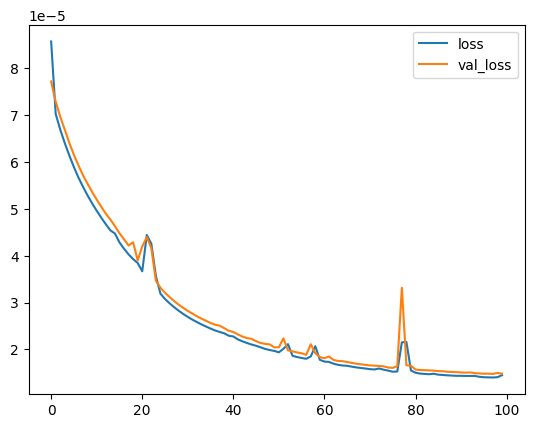

In [24]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

In [38]:
model.load_weights('training_1/vae_best_model.epoch98-loss0.00.w')

In [39]:
test=model.predict(test_data)

6/6 [==============================] - 0s 28ms/step


In [52]:
print(label_test.shape[0])
print('max:' , np.max(test))
print('min:' , np.min(test))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

186
max: 0.9412945
min: -0.3245291


(186, 66, 256, 4)


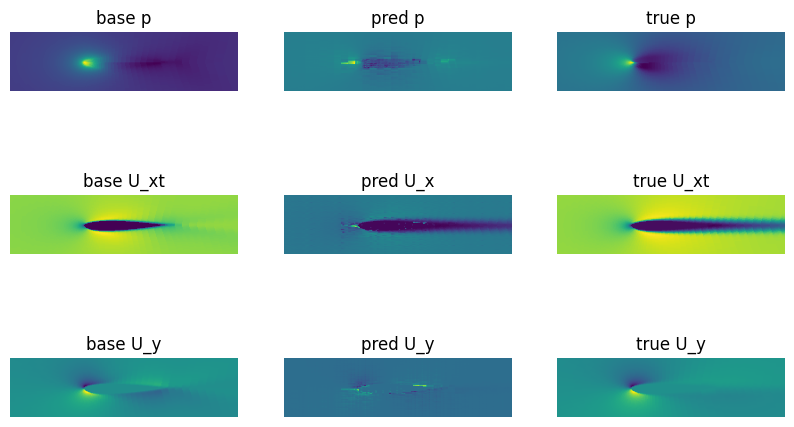

In [65]:
print(test_data.shape)
n=40
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 3, 2)
plt.imshow(test[n,:,:,3])
plt.title('pred p')
plt.axis('off')


fig.add_subplot(3, 3,5)
plt.imshow(test[n,:,:,0])
plt.title('pred U_x')
plt.axis('off')

fig.add_subplot(3, 3, 8)
plt.imshow(test[n,:,:,1])
plt.title('pred U_y')
plt.axis('off')

fig.add_subplot(3, 3, 1)
plt.imshow(test_data[n,:,:,3])
plt.title('base p')
plt.axis('off')


fig.add_subplot(3, 3,4)
plt.imshow(test_data[n,:,:,0])
plt.title('base U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 7)
plt.imshow(test_data[n,:,:,1])
plt.title('base U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1])
plt.title('true U_y')
plt.axis('off')


plt.show()

In [68]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,0],label_test[i,:,:,0]))
    ssim1.append(ssim(test[i,:,:,0],label_test[i,:,:,0]))
print('max mse:'+ str(max(mse)))
print(ssim1[40])
print(mse[40])
mse=np.mean(mse)
print(mse)

max mse:0.00012570477265577153
0.9997756506284078
2.5415597725794595e-07
5.463346099164167e-05
